<a href="https://colab.research.google.com/github/janeisjaded/Error-Detection-in-Radiation-Oncology/blob/main/Error_Detection_in_Radiation_Oncology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **An Investigation of Interpretable Treatment Plan Review AI in Radiation Oncology**


**Link to Data: https://drive.google.com/file/d/18jcAEnjyf3BSWbcLomuzm4O8LULqz-oH/view?usp=share_link**



## **Set up and Data Preprocessing**

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_curve, average_precision_score,
                             roc_auc_score, accuracy_score, recall_score, precision_score, f1_score)

# read in data
# if on google colab, upload the data to Files/content from local machine
raw_data = pd.read_csv("/content/ds340_project_data.csv")
raw_data = raw_data.sort_values(by='tumor_location')

In [ ]:
# data cleaning
# data is already clean enough, so data cleaning is just removing rows with na
def filter_df(df):
    df_clean = df.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.dropna()
    return df_clean.reset_index(drop=True)

normal_data = filter_df(raw_data)
normal_data.head(5)

,tumor_location,ptv_dose_rx,rx_count,dose_per_fraction,total_fractions,beam_count,gantry_angle,mu_per_deg,mu_per_cgy
0,Breast,4664.0,1,180.0,28,1,181.0,4.353334,1.588200
1,Breast,5040.0,4,250.0,30,1,179.0,28.871099,5.907836
2,Breast,6996.0,2,200.0,25,2,181.0,8.040373,2.796995
3,Breast,3000.0,2,200.0,10,5,320.0,2.459738,1.115038
4,Breast,2520.0,1,200.0,5,3,181.0,18.081079,2.097834


In [ ]:
# checking numeric column ranges for reasonable error introduction
numeric_cols = ['ptv_dose_rx', 'rx_count', 'dose_per_fraction',
                'total_fractions', 'beam_count', 'gantry_angle',
                'mu_per_deg', 'mu_per_cgy']

def print_range(df):
  for col in numeric_cols:
    print(f"{col}: {df[col].min()} - {df[col].max()}")

print_range(normal_data)

ptv_dose_rx: 100.0 - 7920.0
rx_count: 0 - 12
dose_per_fraction: 10.0 - 2000.0
total_fractions: 1 - 60
beam_count: 1 - 12
gantry_angle: 0.0 - 358.0
mu_per_deg: 0.0565743591919192 - 143.2
mu_per_cgy: 0.130574406237288 - 27.1657804659052


## **Abnormal Treatment Plans Generation**

In [ ]:
# abnormal data generation
def generate_abnormal_data(df, sample_size):
    # sampling
    sampled_df = df.sample(n=sample_size, replace=True).reset_index(drop=True)
    # error introduction per feature
    permutation_rules = {
        #permutation ranges for each numeric feature
        "ptv_dose_rx": (500, 2000),
        "rx_count": (5, 10),
        "dose_per_fraction": (500, 1000),
        "total_fractions": (10, 50),
        "beam_count": (5, 10),
        "gantry_angle": (100, 250),
        "mu_per_deg": (5, 100),
        "mu_per_cgy": (3, 20),
    }
    # apply permutation rules
    for col, (low, high) in permutation_rules.items():
        if col in sampled_df.columns:
            permutations = np.random.randint(low, high + 1, size=sample_size)
            signs = np.random.choice([-1, 1], size=sample_size)
            adjustments = permutations * signs
            sampled_df[col] = (sampled_df[col] + adjustments).abs()
    return sampled_df

# abnormal_data size is 100, reasonable real-world size
abnormal_data = generate_abnormal_data(normal_data, 100)
abnormal_data.head(5)

,tumor_location,ptv_dose_rx,rx_count,dose_per_fraction,total_fractions,beam_count,gantry_angle,mu_per_deg,mu_per_cgy
0,Breast,3609.0,6,569.0,73,5,387.0,11.075255,21.610644
1,Central nervous system (CNS),291.0,11,976.0,66,10,374.0,21.277396,3.706577
2,Metastasis,6930.0,6,1054.0,26,10,66.0,59.459673,4.008869
3,Breast,5878.0,11,213.0,2,4,467.0,29.656566,11.358347
4,Genitourinary (GU),5337.0,9,588.0,32,14,411.0,98.114338,16.290965


## **Data Preprocessing Continued**

In [ ]:
# one hot encode tumor location and scaling all numeric columns
# normal and abnormal data are both scaled using normal_scaler and encoder,
# because abnormal should match the training distribution

def encode_tumor_location(df, column):
    encoder = OneHotEncoder(sparse_output=False)
    tumor_encoded = encoder.fit_transform(df[[column]])
    tumor_categories = encoder.categories_[0]
    df_encoded = df.copy()
    df_encoded["tumor_location"] = list(tumor_encoded)
    tumor_onehot = encoder
    return df_encoded, tumor_onehot

def standardize_columns(df):
    processed_data = df.copy()
    scaler = StandardScaler()
    scaled_subset = scaler.fit_transform(processed_data[numeric_cols])
    processed_data[numeric_cols] = scaled_subset
    return processed_data, scaler

normal_data, tumor_onehot = encode_tumor_location(normal_data, 'tumor_location')
normal_data, normal_scaler = standardize_columns(normal_data)

abnormal_data["tumor_location"] = list(tumor_onehot.transform(abnormal_data[["tumor_location"]]))
abnormal_data[numeric_cols] = normal_scaler.transform(abnormal_data[numeric_cols])

# temp save data for decision tree models
dt_normal_data = normal_data
dt_abnormal_data = abnormal_data

In [ ]:
normal_data.head(5)

,tumor_location,ptv_dose_rx,rx_count,dose_per_fraction,total_fractions,beam_count,gantry_angle,mu_per_deg,mu_per_cgy
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.473888,-0.76807,-0.456976,1.046673,-1.387681,0.134499,0.230326,-0.552387
1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.678101,2.16347,-0.092436,1.241498,-1.387681,0.111422,4.169641,1.761111
2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.740441,0.20911,-0.352822,0.754436,-0.630922,0.134499,0.822730,0.095016
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.429862,0.20911,-0.352822,-0.706750,1.639356,1.738311,-0.073921,-0.805802
4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.690559,-0.76807,-0.352822,-1.193812,0.125838,0.134499,2.435988,-0.279439


In [ ]:
abnormal_data.head(5)

,tumor_location,ptv_dose_rx,rx_count,dose_per_fraction,total_fractions,beam_count,gantry_angle,mu_per_deg,mu_per_cgy
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.099102,4.117831,1.568825,5.430231,1.639356,2.511371,1.310350,10.171174
1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.901170,9.003731,3.688365,4.748345,5.423151,2.361374,2.949547,0.582167
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1.704595,4.117831,4.094566,0.851848,5.423151,-1.192396,9.084363,0.744068
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.133234,9.003731,-0.285122,-1.486049,0.882597,3.434428,4.295843,4.680279
4,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.839407,7.049371,1.667771,1.436323,8.450187,2.788288,15.295079,7.322076


## **Autoencoder Model Pipline**

In [ ]:
# hold out data for testing
# since autoencoder is only trained on normal data,
# only need to hold out normal_data for testing
test_normal = normal_data.iloc[:1000].copy().reset_index()
normal_data = normal_data.iloc[1000:].copy().reset_index()

# only using numeric columns since passing categorical columns,
# (even one-hot encoded) to autoencoders is problematic
# the reconstructed vector can not be correctly mapped back to a category
test_abnormal = abnormal_data
test_abnormal_numeric = test_abnormal[numeric_cols]

test_normal_numeric = test_normal[numeric_cols]
normal_numeric = normal_data[numeric_cols]
normal_numeric.head(5)

,ptv_dose_rx,rx_count,dose_per_fraction,total_fractions,beam_count,gantry_angle,mu_per_deg,mu_per_cgy
0,1.199495,-0.76807,-0.352822,1.046673,1.639356,0.134499,-0.357047,0.043709
1,-0.429862,0.20911,7.979522,-1.291225,-0.630922,-1.838536,-0.239878,1.042799
2,0.678101,0.20911,-0.009113,-1.291225,-0.630922,0.111422,-0.314008,0.533203
3,0.243606,-0.76807,-0.456976,-1.291225,-0.630922,2.084457,-0.311337,3.829429
4,0.678101,0.20911,-0.003905,-1.193812,0.882597,0.134499,-0.382695,3.778704


In [ ]:
# training data loader, normal plans, to tensors
X_norm_np = normal_numeric.to_numpy(dtype=float)
X_norm = torch.tensor(X_norm_np, dtype=torch.float32)

class train_data(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx]
batch_size = min(64, len(X_norm))
loader = DataLoader(train_data(X_norm), batch_size=batch_size, shuffle=True)

In [ ]:
# autoencoder architecture and pipeline
class Autoencoder(nn.Module):
    def __init__(self, num_dim, latent_dim=3):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(num_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            # latent space
            nn.Linear(32, latent_dim)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # reconstruct original features
            nn.Linear(256, num_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

# equal to number of columns/features
num_dim = X_norm.shape[1]
model = Autoencoder(num_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# training and printing evaluation metrics
model.train()
n_epochs = 50
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for x_batch in loader:
        recon, _ = model(x_batch)
        loss = criterion(recon, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"epoch {epoch+1}, loss: {epoch_loss / len(loader):.4f}")

epoch 1, loss: 0.4396
epoch 2, loss: 0.3189
epoch 3, loss: 0.3063
epoch 4, loss: 0.2823
epoch 5, loss: 0.2703
epoch 6, loss: 0.2625
epoch 7, loss: 0.2569
epoch 8, loss: 0.2494
epoch 9, loss: 0.2492
epoch 10, loss: 0.2457
epoch 11, loss: 0.2417
epoch 12, loss: 0.2428
epoch 13, loss: 0.2371
epoch 14, loss: 0.2320
epoch 15, loss: 0.2305
epoch 16, loss: 0.2233
epoch 17, loss: 0.2186
epoch 18, loss: 0.2180
epoch 19, loss: 0.2198
epoch 20, loss: 0.2187
epoch 21, loss: 0.2135
epoch 22, loss: 0.2133
epoch 23, loss: 0.2084
epoch 24, loss: 0.2059
epoch 25, loss: 0.2078
epoch 26, loss: 0.2105
epoch 27, loss: 0.2037
epoch 28, loss: 0.2076
epoch 29, loss: 0.2055
epoch 30, loss: 0.1982
epoch 31, loss: 0.1934
epoch 32, loss: 0.2024
epoch 33, loss: 0.2074
epoch 34, loss: 0.2024
epoch 35, loss: 0.1997
epoch 36, loss: 0.2001
epoch 37, loss: 0.1990
epoch 38, loss: 0.1940
epoch 39, loss: 0.1960
epoch 40, loss: 0.1948
epoch 41, loss: 0.1954
epoch 42, loss: 0.1944
epoch 43, loss: 0.1962
epoch 44, loss: 0.19

In [ ]:
# setting up testing normal and abnormal plans
test_X_norm_np = test_normal_numeric.to_numpy(dtype=float)
test_X_norm = torch.tensor(test_X_norm_np , dtype=torch.float32)

test_X_ab_np = test_abnormal_numeric.to_numpy(dtype=float)
test_X_ab = torch.tensor(test_X_ab_np, dtype=torch.float32)

In [ ]:
# reconstruction with testing normal and abnormal plans
model.eval()
with torch.no_grad():
    recon_norm, z_norm = model(test_X_norm)
    errors_norm = torch.mean((test_X_norm - recon_norm)**2, dim=1)
    recon_ab, z_ab = model(test_X_ab)
    errors_ab = torch.mean((test_X_ab - recon_ab)**2, dim=1)

print("\nplan mean reconstruction errors:")
print("normal plans mean r-error:", np.round(float(errors_norm.mean()), 3))
print("abnormal plans mean r-error:", np.round(float(errors_ab.mean()), 3))


plan mean reconstruction errors:
normal plans mean r-error: 0.169
abnormal plans mean r-error: 12.797


In [ ]:
# visualizing 3d latent space
# interpretability 1
z_norm_np = z_norm.numpy()
z_ab_np = z_ab.numpy()

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=z_norm_np[:,0], y=z_norm_np[:,1], z=z_norm_np[:,2],
    mode='markers',
    marker=dict(size=6, color='darkgreen'),
    name='Normal'))
fig.add_trace(go.Scatter3d(
    x=z_ab_np[:,0], y=z_ab_np[:,1], z=z_ab_np[:,2],
    mode='markers',
    marker=dict(size=6, color='red', symbol='x'),
    name='Abnormal'))
fig.update_layout(
    title="3D latent space visualization (normal vs abnormal plans)",
    scene=dict(
        xaxis_title="Latent 1",
        yaxis_title="Latent 2",
        zaxis_title="Latent 3"),
    width=1000,
    height=1000,
    legend = dict(font=dict(size=20)))
fig.show()

In [ ]:
# passing testing plans for parameter reconstruction examples
# interpretability 2
def vector_to_dict(vec, cols):
    return {col: float(f"{v:.4f}") for col, v in zip(cols, vec)}

def reconstruct_examples(dataset_tensor, dataset_name, scaler, n=3):
    idxs = random.sample(range(dataset_tensor.shape[0]), min(n, dataset_tensor.shape[0]))
    for i in idxs:
        x = dataset_tensor[i].unsqueeze(0)
        with torch.no_grad():
            recon, _ = model(x)
        # reconstruction error
        error = float(torch.mean((x - recon)**2).item())
        x_np = x.numpy()[0]
        recon_np = recon.numpy()[0]
        # inverse scaling parameter values
        orig_unscaled = scaler.inverse_transform(x_np.reshape(1,-1))[0]
        recon_unscaled = scaler.inverse_transform(recon_np.reshape(1,-1))[0]

        print(f"\n{dataset_name}")
        print("\nOriginal Plan:")
        print(vector_to_dict(orig_unscaled, numeric_cols))
        print("\nReconstructed plan:")
        print(vector_to_dict(recon_unscaled, numeric_cols))
        print(f"\nReconstruction Error: {error:.3f}")
        print("_________________________________________________________________")

def inspect_normals(scaler):
    reconstruct_examples(test_X_norm, "Normal", scaler, n=5)
def inspect_abnormals(scaler):
    reconstruct_examples(test_X_ab, "Abnormal", scaler, n=5)

inspect_normals(normal_scaler)
inspect_abnormals(normal_scaler)


Normal

Original Plan:
{'ptv_dose_rx': 4500.0, 'rx_count': 4.0, 'dose_per_fraction': 180.0, 'total_fractions': 5.0, 'beam_count': 5.0, 'gantry_angle': 296.0, 'mu_per_deg': 1.5597, 'mu_per_cgy': 0.9967}

Reconstructed plan:
{'ptv_dose_rx': 4420.3823, 'rx_count': 4.0985, 'dose_per_fraction': 268.7319, 'total_fractions': 7.1254, 'beam_count': 4.1402, 'gantry_angle': 261.0249, 'mu_per_deg': 0.9163, 'mu_per_cgy': 2.44}

Reconstruction Error: 0.183
_________________________________________________________________

Normal

Original Plan:
{'ptv_dose_rx': 3420.0, 'rx_count': 2.0, 'dose_per_fraction': 180.0, 'total_fractions': 25.0, 'beam_count': 2.0, 'gantry_angle': 179.0, 'mu_per_deg': 0.7409, 'mu_per_cgy': 1.3519}

Reconstructed plan:
{'ptv_dose_rx': 3483.9109, 'rx_count': 2.2687, 'dose_per_fraction': 227.7961, 'total_fractions': 21.8311, 'beam_count': 1.9948, 'gantry_angle': 173.1524, 'mu_per_deg': 1.2762, 'mu_per_cgy': 1.5018}

Reconstruction Error: 0.031
__________________________________

In [ ]:
# autoencoder evaluation
# set max recon error from normal plans as threshold to flag a plan as abnormal
# use threshold to calculate accuracy, recall, precision, f1,
# with test normal and test abnormal data

threshold = errors_norm.max().item()

def flag_abnormal(recon_errors, threshold):
    return (recon_errors > threshold).int()

def autoencoder_evaluation(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, rec, prec, f1

print(f"Threshold for flagging plan as abnormal (max normal r-error): {threshold:.3f}")
testing_set = torch.cat([test_X_norm, test_X_ab], dim=0)
true_labels = torch.cat([torch.zeros(test_X_norm.shape[0]), torch.ones(test_X_ab.shape[0])], dim=0)
with torch.no_grad():
    recon_combined, _ = model(testing_set)
    errors_combined = torch.mean((testing_set - recon_combined)**2, dim=1)

pred_labels = flag_abnormal(errors_combined, threshold)
accuracy, recall, precision, f1 = autoencoder_evaluation(true_labels.numpy(), pred_labels.numpy())
print("\nAutoencoder evaluation:")
print(f"Accuracy on testing_set: {accuracy:.3f}")
print(f"Recall on testing_set: {recall:.3f}")
print(f"Precision on testing_set: {precision:.3f}")
print(f"F1 on testing_set: {f1:.3f}")

Threshold for flagging plan as abnormal (max normal r-error): 2.722

Autoencoder evaluation:
Accuracy on testing_set: 0.993
Recall on testing_set: 0.920
Precision on testing_set: 1.000
F1 on testing_set: 0.958


## **Decision Tree Models Pipeline**

In [ ]:
# combine normal and abnormal datasets, add binary labels
normal_data = dt_normal_data
abnormal_data = dt_abnormal_data

normal_data['label'] = 0
abnormal_data['label'] = 1
combined_data = (pd.concat([normal_data, abnormal_data], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True))

# decision tree training, validation, testing data
tumor_array = np.stack(combined_data['tumor_location'].to_numpy())
X_numeric = combined_data[numeric_cols].to_numpy()
X = np.hstack([X_numeric, tumor_array])
y = combined_data['label'].to_numpy()
X_train_raw,X_temp,y_train_raw,y_temp=train_test_split(X,y,test_size=0.40,stratify=y,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.50,stratify=y_temp,random_state=42)
pos=(y_train_raw==1).sum()

# dealing with little abnormal plan data
rus=RandomUnderSampler(sampling_strategy={0:pos*9,1:pos},random_state=42)
X_train_bal,y_train_bal=rus.fit_resample(X_train_raw,y_train_raw)

# decision tree models evaluation
def eval_model(name,probs,y,thr=0.5):
    preds=(probs>thr).astype(int)
    rpt=classification_report(y,preds,output_dict=True)
    return{"Model":name,
        "Accuracy":rpt["accuracy"],
        "Precision":rpt["1"]["precision"],
        "Recall":rpt["1"]["recall"],
        "F1":rpt["1"]["f1-score"],
        "ROC-AUC":roc_auc_score(y,probs)}

### **XGBoost Model:**

In [ ]:
# XGBoost model hyperparameters and training
neg,pos_bal=(y_train_bal==0).sum(),(y_train_bal==1).sum()
spw=neg/pos_bal
xgb=XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=spw,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_bal,y_train_bal,eval_set=[(X_val,y_val)],verbose=False)
probs_xgb_val=xgb.predict_proba(X_val)[:,1]

### **LightGBM Model:**

In [ ]:
# LightGBM model hyperparameters and training
lgbm=LGBMClassifier(
    objective="binary",
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight={0:1.0,1:spw},
    random_state=42,
    n_jobs=-1
)
lgbm.fit(X_train_bal,y_train_bal,eval_set=[(X_val,y_val)],eval_metric="binary_logloss")
probs_lgbm_val=lgbm.predict_proba(X_val)[:,1]

[LightGBM] [Info] Number of positive: 60, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



### **Ensemble Model (XGBoost + LightGBM + FocalNet):**

In [ ]:
# Ensemble model (XGBoost + LightGBM + FocalNet NN)
# model architecture and training
device=torch.device("cpu")
X_train_t=torch.tensor(X_train_bal,dtype=torch.float32)
y_train_t=torch.tensor(y_train_bal,dtype=torch.float32).unsqueeze(1)
X_val_t=torch.tensor(X_val,dtype=torch.float32)
y_val_t=torch.tensor(y_val,dtype=torch.float32).unsqueeze(1)

class FocalLoss(nn.Module):
    def __init__(self,alpha=0.75,gamma=2.0):
        super().__init__()
        self.alpha=alpha
        self.gamma=gamma
    def forward(self,logits,targets):
        bce=nn.functional.binary_cross_entropy_with_logits(logits,targets,reduction='none')
        p=torch.sigmoid(logits)
        p_t=p*targets+(1-targets)*(1-p)
        return (self.alpha*(1-p_t)**self.gamma*bce).mean()

# FocalNet NN architecture
class FocalNet(nn.Module):
    def __init__(self,d):
        super().__init__()
        self.m=nn.Sequential(
            nn.Linear(d,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32,1)
        )
    def forward(self,x):
      return self.m(x)

fn=FocalNet(X_train_bal.shape[1]).to(device)
opt=optim.Adam(fn.parameters(),lr=5e-4,weight_decay=1e-4)
crit=FocalLoss()
best=float("inf")
pat=10
ctr=0

# training with early stopping
for ep in range(50):
    fn.train()
    opt.zero_grad()
    loss=crit(fn(X_train_t),y_train_t)
    loss.backward()
    opt.step()
    fn.eval()
    with torch.no_grad():
      vl=crit(fn(X_val_t),y_val_t).item()
    if vl<best-1e-5:
        best=vl
        best_state={k:v.clone() for k,v in fn.state_dict().items()}
        ctr=0
    else:
        ctr+=1
        if ctr>=pat:
          break

fn.load_state_dict(best_state)
fn.eval()
with torch.no_grad():
  probs_fn_val=torch.sigmoid(fn(X_val_t)).numpy().ravel()

# ensemble model, mean of 3 model probabilities
probs_ens_val=(probs_xgb_val+probs_lgbm_val+probs_fn_val)/3

## **Decision Tree Models & Autoencoder Evaluation**

In [ ]:
# decision tree models results
res = []
res.append(eval_model("XGBoost", probs_xgb_val, y_val))
res.append(eval_model("LightGBM", probs_lgbm_val, y_val))
res.append(eval_model("Ensemble", probs_ens_val, y_val))

# autoencoder results
acc_ae, rec_ae, prec_ae, f1_ae = autoencoder_evaluation(true_labels.numpy(), pred_labels.numpy())

# summary dataframe
# note, precision is number of positives that were actually positive
df = pd.DataFrame(res).set_index("Model")
metrics_dict = {
    "Autoencoder": {"Accuracy": round(acc_ae, 3), "Recall": round(rec_ae, 3), "Precision": round(prec_ae, 3), "F1": round(f1_ae, 3)},
    "XGBoost": {
        "Accuracy": round(df.loc["XGBoost", "Accuracy"], 3),
        "Recall": round(df.loc["XGBoost", "Recall"], 3),
        "Precision": round(df.loc["XGBoost", "Precision"], 3),
        "F1": round(df.loc["XGBoost", "F1"], 3)
    },
    "LightGBM": {
        "Accuracy": round(df.loc["LightGBM", "Accuracy"], 3),
        "Recall": round(df.loc["LightGBM", "Recall"], 3),
        "Precision": round(df.loc["LightGBM", "Precision"], 3),
        "F1": round(df.loc["LightGBM", "F1"], 3)
    },
    "Ensemble": {
        "Accuracy": round(df.loc["Ensemble", "Accuracy"], 3),
        "Recall": round(df.loc["Ensemble", "Recall"], 3),
        "Precision": round(df.loc["Ensemble", "Precision"], 3),
        "F1": round(df.loc["Ensemble", "F1"], 3)
    }
}

df_final = pd.DataFrame(metrics_dict)
df_final = df_final.loc[["Accuracy", "Recall", "Precision", "F1"]]
df_final

,Autoencoder,XGBoost,LightGBM,Ensemble
Accuracy,0.993,0.998,0.996,0.997
Recall,0.920,0.950,0.950,0.950
Precision,1.000,0.792,0.679,0.760
F1,0.958,0.864,0.792,0.844


<Figure size 1500x1000 with 0 Axes>

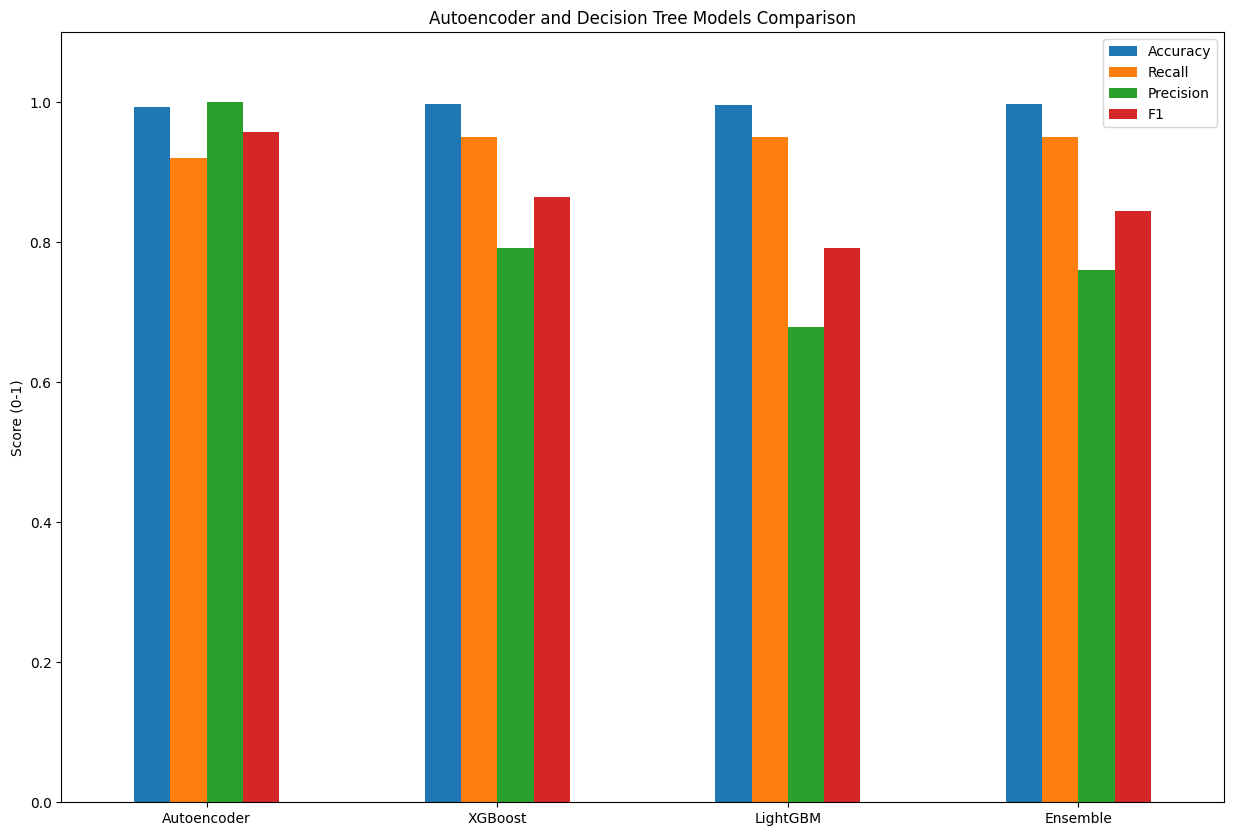

In [ ]:
# summary bar chart
plt.figure(figsize=(15,10))
df_final.T.plot(kind="bar", figsize=(15,10))
plt.title("Autoencoder and Decision Tree Models Comparison")
plt.ylabel("Score (0-1)")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(0, 1.1)
plt.show()